In [1]:
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"
sys.path.append(str(src_path))

import data_preprocessing as dp
import model_evaluation as me

In [2]:
import pandas as pd
import numpy as np
import random

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dropout, Activation, Bidirectional
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

# get data using andrew's clean data functions

In [4]:
cleaned_df = dp.df_clean(lem=False)

In [5]:
cleaned_df.head(5)

,emotion,txt_cleaned
0,0,product_target hrs tweeting riseaustin dead ne...
1,2,know awesome ipadiphone product_target youll l...
2,2,wait product_target also sale sxsw
3,0,hope years festival isnt crashy years iphone p...
4,2,great stuff fri sxsw marissa mayer product_tar...


In [6]:
y = cleaned_df['emotion']
y

0       0
1       2
2       2
3       0
4       2
       ..
9077    2
9079    2
9080    0
9085    2
9088    2
Name: emotion, Length: 3282, dtype: int64

In [7]:
X = cleaned_df['txt_cleaned']
X

0       product_target hrs tweeting riseaustin dead ne...
1       know awesome ipadiphone product_target youll l...
2                      wait product_target also sale sxsw
3       hope years festival isnt crashy years iphone p...
4       great stuff fri sxsw marissa mayer product_tar...
                              ...                        
9077    pr guy convinced switch back product_target gr...
9079    quotpapyrussort like ipadquot nice lol sxsw la...
9080    diller says google tv quotmight run playstatio...
9085    ive always used camera iphone bc image stabili...
9088                       product_target everywhere sxsw
Name: txt_cleaned, Length: 3282, dtype: object

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
y_train = pd.get_dummies(y_train)
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train, test_size=.1)

# tokenize tweets

In [9]:
X_train_list = list(X_train)
X_test_list = list(X_test)
X_tr_list = list(X_tr)
X_v_list = list(X_v)

X_train_corpus = []
X_tr_corpus = []
for tweet in X_train_list:
    X_train_corpus.extend(tweet.split(' '))
for tweet in X_tr_list:
    X_tr_corpus.extend(tweet.split(' '))
    
X_train_unique = len(set(X_train_corpus))
X_tr_unique = len(set(X_tr_corpus))

In [10]:
sequence_length = 100

partial_tokenizer = text.Tokenizer(num_words=X_tr_unique)
full_tokenizer = text.Tokenizer(num_words=X_train_unique)

partial_tokenizer.fit_on_texts(X_tr_list)
full_tokenizer.fit_on_texts(X_train_list)

X_tr_tokenized = partial_tokenizer.texts_to_sequences(X_tr_list)
X_v_tokenized = partial_tokenizer.texts_to_sequences(X_v_list)
X_train_tokenized= full_tokenizer.texts_to_sequences(X_train_list)
X_test_tokenized= full_tokenizer.texts_to_sequences(X_test_list)

X_tr_tokens = sequence.pad_sequences(X_tr_tokenized, maxlen=sequence_length)
X_v_tokens = sequence.pad_sequences(X_v_tokenized, maxlen=sequence_length)
X_train_tokens = sequence.pad_sequences(X_train_tokenized, maxlen=sequence_length)
X_test_tokens = sequence.pad_sequences(X_test_tokenized, maxlen=sequence_length)

#### ^^^ modified for train_test_split variables up to here

# construct CNN with embedding layer

In [11]:
partial_model = Sequential()

embedding_size = 128
partial_model.add(Embedding(input_dim=len(set(X_tr_corpus)), output_dim=embedding_size, input_length=sequence_length))
partial_model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
partial_model.add(Dropout(0.5))
partial_model.add(MaxPooling1D(pool_size=2))
partial_model.add(Flatten())
partial_model.add(Dense(units=30, activation='tanh'))
partial_model.add(Dense(units=3, activation='softmax'))
partial_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model on tokenized data

In [12]:
partial_model.fit(X_tr_tokens, y_tr, validation_data=(X_v_tokens, y_v), epochs=7, batch_size=32)

Epoch 1/7
74/74 [==============================] - 1s 19ms/step - loss: 0.5878 - accuracy: 0.8065 - val_loss: 0.5983 - val_accuracy: 0.8137
Epoch 2/7
74/74 [==============================] - 1s 20ms/step - loss: 0.4316 - accuracy: 0.8319 - val_loss: 0.4821 - val_accuracy: 0.8403
Epoch 3/7
74/74 [==============================] - 2s 23ms/step - loss: 0.2254 - accuracy: 0.9234 - val_loss: 0.5411 - val_accuracy: 0.8441
Epoch 4/7
74/74 [==============================] - 1s 17ms/step - loss: 0.1268 - accuracy: 0.9589 - val_loss: 0.6047 - val_accuracy: 0.8517
Epoch 5/7
74/74 [==============================] - 2s 20ms/step - loss: 0.0966 - accuracy: 0.9678 - val_loss: 0.6183 - val_accuracy: 0.8175
Epoch 6/7
74/74 [==============================] - 1s 19ms/step - loss: 0.0693 - accuracy: 0.9738 - val_loss: 0.6812 - val_accuracy: 0.8175
Epoch 7/7
74/74 [==============================] - 1s 19ms/step - loss: 0.0510 - accuracy: 0.9848 - val_loss: 0.7036 - val_accuracy: 0.8403


# train model on full train split for validation on 'test'

In [13]:
full_model = Sequential()

embedding_size = 128
full_model.add(Embedding(input_dim=len(set(X_train_corpus)), output_dim=embedding_size, input_length=sequence_length))
full_model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
full_model.add(Dropout(0.5))
full_model.add(MaxPooling1D(pool_size=2))
full_model.add(Flatten())
full_model.add(Dense(units=30, activation='tanh'))
full_model.add(Dense(units=3, activation='softmax'))
full_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
full_model.fit(X_train_tokens, y_train, validation_data=(X_test_tokens, pd.get_dummies(y_test)), epochs=7, batch_size=32)

Epoch 1/7
83/83 [==============================] - 2s 23ms/step - loss: 0.5808 - accuracy: 0.8114 - val_loss: 0.5532 - val_accuracy: 0.8158
Epoch 2/7
83/83 [==============================] - 2s 19ms/step - loss: 0.4327 - accuracy: 0.8404 - val_loss: 0.4367 - val_accuracy: 0.8539
Epoch 3/7
83/83 [==============================] - 1s 17ms/step - loss: 0.2122 - accuracy: 0.9295 - val_loss: 0.4408 - val_accuracy: 0.8569
Epoch 4/7
83/83 [==============================] - 1s 17ms/step - loss: 0.1198 - accuracy: 0.9604 - val_loss: 0.4769 - val_accuracy: 0.8584
Epoch 5/7
83/83 [==============================] - 1s 17ms/step - loss: 0.0799 - accuracy: 0.9722 - val_loss: 0.5365 - val_accuracy: 0.8524
Epoch 6/7
83/83 [==============================] - 1s 18ms/step - loss: 0.0556 - accuracy: 0.9829 - val_loss: 0.6123 - val_accuracy: 0.8584
Epoch 7/7
83/83 [==============================] - 1s 18ms/step - loss: 0.0460 - accuracy: 0.9882 - val_loss: 0.6522 - val_accuracy: 0.8569


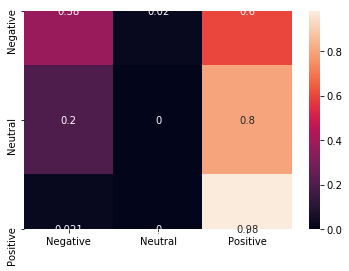

In [15]:
me.plot_confusion_matrix(y_test, np.argmax(full_model.predict(X_test_tokens), axis=1))

In [16]:
confusion_matrix(y_test, np.argmax(full_model.predict(X_test_tokens), axis=1))

array([[ 38,   2,  61],
       [  4,   0,  16],
       [ 11,   0, 525]])